# Summary

**TODO: Summarize. POKT Summary is below.**

The **Gateway Viability** scenario group is a series of simulations designed to help inform the specification of protocol parameters assumed to impact the gateway role in the ecosystem. The scenarios cover a variety of different demand environments for network services by varying both the number of applications and the number of relay requests. Different combinations of protocol parameter values generate different simulation outcomes, that are summarized by key peformance indicators (KPIs). The KPIs are then assessed according to desired values (success criteria), using _threshold inequalities_ generated from threshold values for KPIs that meet stakeholder criteria.

Because an exhaustive 'sweep' of every possible combination of relevant protocol parameters is computationally infeasible, this study has instead performed an **adaptive search**, whereby a coarse initial grid of parameters is successively refined by applying the success criteria to generated KPIs, and inferring a new 'direction' of search for a succeeding grid. Convergence is achieved when all success criteria are met across the performed simulations. Although it is always possible that multiple "equilibria" exist, such that success criteria are met by parameter combinations that are not found from adaptive search, the initial grid is informed by existing parameter values from the Pocket network and hence benefit from the expert knowledge used to define those initial values. 

Future work can perform a more thorough search of the underlying parameter space, in addition to performing more demand scenarios and realizations from the exogenous distributions that represent external factors.

# Contents

**TODO: Summarize. POKT Contents are below.**


**Experimental Setup**: This covers the objective of the study and its methodology, describes the KPIs and success indicators (threshold inequalities), the protocol and environmental sweep parameters and their initial ranges, and finally summarizes the computational complexity of the simulations themselves.

**Adaptive Grid Results**: The evolution of the parameter selection process is presented as a visualization, showing the convergence of the protocol parameter ranges as different success criteria are achieved.

**Protocol Parameter Recommendations**: Based upon the adaptive grid results, the recommended parameter ranges are presented.

**Decision Tree and Parameter Importance**: Using the adaptive grid results, a machine-learning process is applied to infer the importance of different parameters on the associated KPI-based threshold inequalities. This provides a method of assessing whether one or more parameters are 'crucial' to success, in the sense that they have an outsized impact on the success criteria. This approach leverages decision trees that are fit to the results of the entire adaptive grid process.

**Parameter Impact on KPIs**: A density approach (histogram) can be used to assess the impact of protocol parameters on the KPIs of the scenario. The KPI densities are shown for each protocol parameter sweep value, providing a visual indication of the impact of the parameter on the density shape and location.

**Conclusion**: An overall assessment of the scenario results is provided, highlighting any problems, caveats, implications and possibilities for future/extended work.

# Experimental Setup

**TODO: Experimental Setup. POKT Setup is below.** 

## Objective and Methodology

The objective of the gateway viability scenario group is to understand the economic incentives to become and to remain a gateway, while ensuring that the ecosystem as a whole remains viable.

- **System Goals Targeted**:
  - Economic Viability
  - Accessibility
- **Design**: create different demand-side circumstances (e.g. application growth, relay per application growth) that impact gateway profitability
- **Testing Variables**:
  - Environmental:
      - Introduce different application arrival rates, by changing the maximum number of applications that can exist in the simulation. This is a proxy for different demand scenarios for the network's services based upon the entities that require services. Alternatively, it may be thought of as introducing different capacity constraints of the network to handle application traffic.
      - Introduce different relay traffic rates per session, by changing the expected value of relay traffic. This is a proxy for different demand scenarios for the network's services per application--a low value means applications participating in the network are 'light' in relay requests, while a high value implies that applications are requesting many relays per session and are thus 'heavy' in resource demand.
  - Protocol:
      - Assess the impact of different `TokenToRelaysMultiplier` (TTRM) values. The TTRM is the rate limiter used to convert a gateway's stake into bandwidth for handling relay traffic. A high TTRM relaxes this rate limiter, while a small TTRM restricts bandwidth and (in this simulation) reduces gateway profitability as relays served falls.
      - Assess the impact of different `GatewayFeePerRelay` (GFPR) values. This is a direct cost assessed to gateways from having their relays served.
      - Assess the impact of different `ApplicationFeePerRelay` (AFPR) values. A higher 'wedge' between GFPR and AFPR incentivizes (on the margine) one type of participant over the other.
      - Assess the impact of different `GatewayMinimumStake` (GMS) values. This is a running cost that must be fulfilled in order to participate as a gateway, and has an associated opportunity cost (value of using staked funds for an alternative use, proxied here by its investment in a risk-free instrument paying a 5% annual rate of return).
      - Assess the impact of different `ApplicationMinimumStake` (AMS) values. To prevent barriers to entry it is generally accepted that AMS < GMS, as applications are expected to operate on a smaller scale. But AMS values impact gateway profitability as well, having an impact on general relay traffic and rate-limiting via the TTRM.

## KPIs

**TODO: Explain KPIs. POKT KPIs are below.**

- Servicer NPV (KPI-1): This measures whether or not servicers are profitable.
- Gateway NPV (KPI-3): The main KPI for this scenario group. This measures whether or not gateways are profitable.
- Servicer Capital Costs per Unit of Reward (KPI-14): This is an ancillary KPI to KPI-1 and KPI-3, and measures the trade-off that exists between the opportunity cost of being a servicer and the expected reward. Intuitively, the ecosystem should not 1) make it more attractive for servicers to exit the ecosystem (even if profitable), or 2) reduce security by rewarding participation to the extent that the stake does not become a deterrent to undesirable behavior.

## Threshold Inequalities

**TODO: Delete or replace. Explain above median methodology.**

1. (**Servicer Capital Costs**) The average servicer cost per unit of reward must lie between $0.1$ and $0.9$. This inequality restriction is referenced in the code as `servicer_capital_costs_success`.
2. (**Servicer NPV**) The fraction of the Monte Carlo simulations for which Servicer NPV is greater than $750$ POKT must be at least $90$%. This inequality restriction is referenced in the code as `servicer_npv_success`.
3. (**Gateway NPV**) The fraction of the Monte Carlo simulations for which Gateway NPV is greater than $7500$ POKT must be at least $90$%. This inequality is referenced in the code as `gateway_npv_success`.

## Sweep Parameters

**TODO: Revise. This can be copy-pasted from Markdown document. POKT information is below.**

### Swept Protocol Parameters

1. `TokenToRelaysMultiplier` (`TTRM`)
2. `GatewayFeePerRelay` (`GFPR`)
3. `ApplicationFeePerRelay` (`AFPR`)
4. `GatewayMinimumStake` (`GMS`)
5. `ApplicationMinimumStake` (`AMS`)

### Swept Environmental Parameters

1. Maximum number of applications in the simulation, `application_max_number`. Sweeping this parameter changes the arrival rate of applications by adjusting the time before the network is 'saturated'.
2. Average arrival rate of the relay request process, `relays_per_session_gamma_distribution_scale`. Coupled with the parameter `relays_per_session_gamma_distribution_shape`, this sets the expected value of the number of relays in a session, which is modeled using a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) having these scale and shape parameter values.

## Initial Parameter Sweep Ranges

**TODO: Revise. POKT information is below.**

Protocol and Environmental parameters were initialized for the first adaptive grid search according to:
1. Values found in the specifications provided to BlockScience ([V1 Mechanism spreadsheet](https://docs.google.com/spreadsheets/d/1Gpnw3ZXNh9lWFgmrbrg8wTqVKPD2M8QqJdAiAALru38/edit?usp=sharing), [V1 Minting spreadsheet](https://docs.google.com/spreadsheets/d/1QYe6NzuiyimsXs5cT1BSM-UT1DtX_K38cOZsEFJOtdA/edit?usp=sharing)),
2. Discussions with the Pocket team, and
3. BlockScience best practice. 

### Environmental Parameters

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| Maximum Number of Applications  | `application_max_number` |(5, 20, 100) | number |
| Relays Per Session Gamma Distribution Scale  | `relays_per_session_gamma_distribution_scale` | (1e5, 3e5, 9e5) | relays/day |

### Protocol Parameters

| Full Name |  Sweep Variable Name | Sweep Values | Units |
| --- | --- | ---| ---|
| `TokenToRelaysMultiplier`  | `session_token_bucket_token_coefficient` | (25, 400) | relay/uPOKT |
| `GatewayFeePerRelay`       | `gateway_fee_per_relay` | (10, 100) | uPOKT/relay |
| `ApplicationFeePerRelay`   | `application_fee_per_relay` | (10, 100) | uPOKT/relay |
| `GatewayMinimumStake`      | `gateway_minimum_stake`  | (1e5, 2e5) | POKT |
| `ApplicationMinimumStake`  | `minimum_application_stake`  | (1e4, 2e4)  | POKT |

## Computational Complexity

**TODO: Update. POKT information is below.** 

**Total number of parameter constellations**: 288

**Total number of Monte Carlo runs per constellation**: 5

**Total number of experiments per adaptive grid**: 1,440

**Number of adaptive grid searches**: 6

**Total number of parameter constellations evaluated**: 8,640

# Results

In [1]:
import os
os.chdir("..")

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from aztec_gddt.metrics import *
from aztec_gddt.plot_tools import *     

In [3]:
FILENAME_TO_USE = "data/2024-04-02T19:35:23Z-13-trajectory_tensor.csv.gz" # Replace with actual filename

# Protocol Parameter Recommendations

**TODO:** I don't think we are making parameter recommendations here? 

| Full Name |  Abbreviation | Recommended Range | Units |
| --- | --- | ---| ---|
| `TokenToRelaysMultiplier`| `session_token_bucket_token_coefficient` | (71.875, 83.59735) | relay/uPOKT |
| `GatewayFeePerRelay` | `gateway_fee_per_relay` |  (10, 12.8125) | uPOKT/relay |
| `ApplicationFeePerRelay` | `application_fee_per_relay` | (26.875, 29.6875) | uPOKT/relay |
| `GatewayMinimumStake`  | `gateway_minimum_stake`  | (1.22e5, 1.25e5) | POKT |
| `ApplicationMinimumStake`  | `minimum_application_stake` | (1.35e4, 1.38e4)  | POKT |

# Decision Tree and Parameter Importance

## Decision Tree Classification

**NOTE:** This part stays the same, though we might revise the prose if desired. 

A decision tree is a machine-learning-based classifier. Given the simulation results, for each threshold inequality the tree recursively associates different _samples_ from the results, according to sorting criteria based upon one or more of the protocol parameters of the simulation. 

Each decision tree below corresponds to one of the threshold inequalities stated above. Where the decision tree is 'empty', the threshold inequality was either 1) always fulfilled during the simulations, or 2) never fulfilled during the simulations. In this case no sensitivity analysis can be performed, as the threshold inequalities do not vary according to the different parameter combinations that were swept.

The title of the decision tree includes the threshold inequality under scrutiny, in addition to a technical 'score' (usually "100%") and the number of simulation results used as the dataset. Within the decision tree presented, each **non-terminal** 'node' is labeled with the following information:

1. The sorting variable used and its cutoff value used for classification, in the form of `parameter_name <= x` where `x` is the cutoff value. Branches to the left of this node indicate _satisfaction_ of this inequality, while branches to the right indicate _violation_, i.e. `parameter_name > x`.
2. A Gini coefficient representing the method of recursive association used.
3. The total number of simulation results ("samples = y%") as a percentage "y" that are considered at this node.
4. The breakdown of the simulation results considered into left and right branches ("value = [p, 1-p]"), where "p" is the fraction of results that satisfy the `parameter_name <= x` constraint, and "1-p" the fraction satisfying `parameter_name > x`.
5. The classification of the majority of the simulation results at this node (note that this is not a final classification, as it appears in a non-terminal node, and can be arbitrary if the results are split equally across classes).

**Terminal** nodes ("leaves") represent the final classification of that proportion of the simulation results that arrive at the node, and have most of the same information as a non-terminal node, with the exception that there is no branching performed and hence no sorting variable displayed. Here the most important information is the classification (last line).

Non-terminal and terminal nodes colored in blue correspond to the threshold inequality being met, and by following blue boxes from a terminal node up to the root of tree a set of `parameter_name <= x` and/or `parameter_name > x` sorting criteria can be chained together. 

Upon successful classification, it is usual for the terminal node to have a breakdown "value = [1.0, 0.0]" or "value = [0.0, 1.0]", indicating that 100% of the remaining simulation results treated are either satisfying the threshold inequality under treatment (left value is 1.0), or not satisfying the threshold inequality (right value is 1.0).

For further information regarding the decision tree approach adopted here please see the [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#) documentation for the scikit-learn library.

## Feature Importance

Below each non-empty decision tree is a bar graph indicating the relative importance of each swept protocol parameter ("feature") in determining the satisfaction of the threshold inequality. This leverages the use of "random forests", which is a technique to average over many different decision tree realizations over different subsets of the simulation results, assessing the relative contribution of each protocol parameter in the branching of each tree. Roughly speaking, the more times a protocol parameter was used in the branching process, the higher its importance is to the threshold inequality--in other words, the protocol parameter carries a larger 'weight' in determining satisfaction or violation of the inequality, and so the inequality is more sensitive to the values of the parameter.

For further information regarding the random forest and feature importance approach adopted here please see the [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) documentation from the `scikit-learn` library.

In [4]:
# KPI_cols = ["proportion_race_mode",
#         "proportion_slashed_prover",
#         "proportion_slashed_sequencer",
#         "proportion_skipped",
#         "average_duration_finalized_blocks",
#         "stddev_duration_finalized_blocks",
#         "average_duration_nonfinalized_blocks",
#         "stddev_duration_nonfinalized_blocks",
#          "delta_total_revenue_agents"
#          ]

base_df = add_additional_info(pd.read_csv(FILENAME_TO_USE))
#base_df = pd.read_csv(FILENAME_TO_USE)

# if "roportion_slashed_prover" in base_df.columns:
#         base_df["proportion_slashed_prover"] = base_df["roportion_slashed_prover"]

In [5]:
base_df.columns

Index(['simulation', 'subset', 'run', 'phase_duration_proposal_min_blocks',
       'phase_duration_proposal_max_blocks',
       'phase_duration_reveal_min_blocks', 'phase_duration_reveal_max_blocks',
       'phase_duration_commit_bond_min_blocks',
       'phase_duration_commit_bond_max_blocks',
       'phase_duration_rollup_min_blocks', 'phase_duration_rollup_max_blocks',
       'phase_duration_race_min_blocks', 'phase_duration_race_max_blocks',
       'reward_per_block', 'proportion_race_mode', 'proportion_slashed_prover',
       'proportion_slashed_sequencer', 'proportion_skipped',
       'average_duration_finalized_blocks', 'stddev_duration_finalized_blocks',
       'average_duration_nonfinalized_blocks',
       'stddev_duration_nonfinalized_blocks', 'delta_total_revenue_agents',
       'is_proposal_fixed', 'is_reveal_fixed', 'is_commit_bond_fixed',
       'is_rollup_fixed', 'is_race_fixed'],
      dtype='object')

In [6]:

for col in ["run", "simulation", "subset"]:
    if col in base_df.columns:
        base_df.drop(columns = [col], inplace = True)


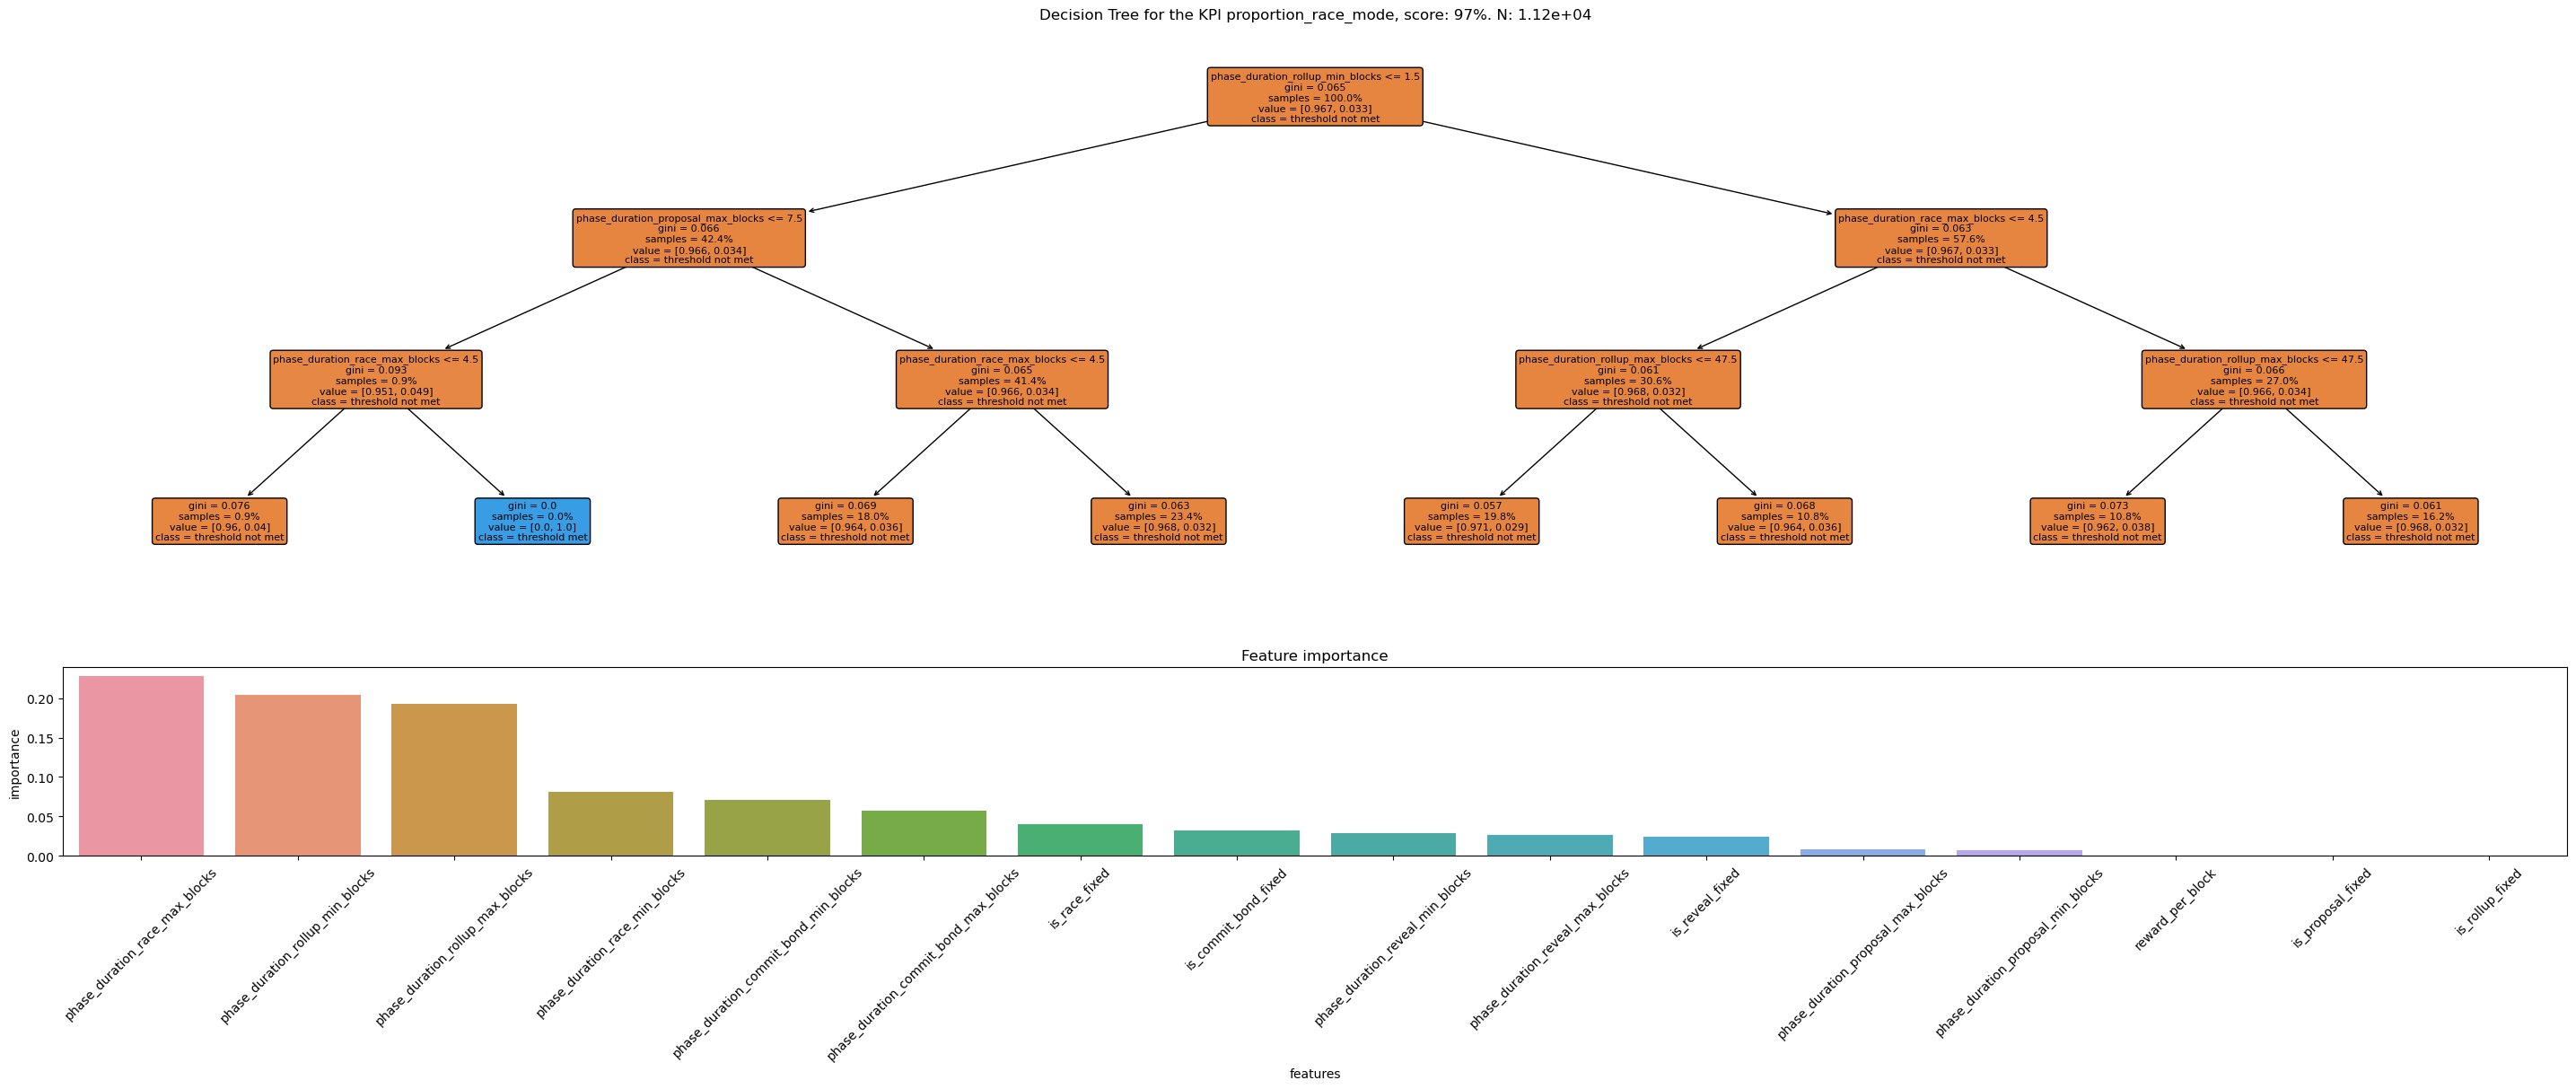

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI proportion_race_mode, score: 97%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [7]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "proportion_race_mode")

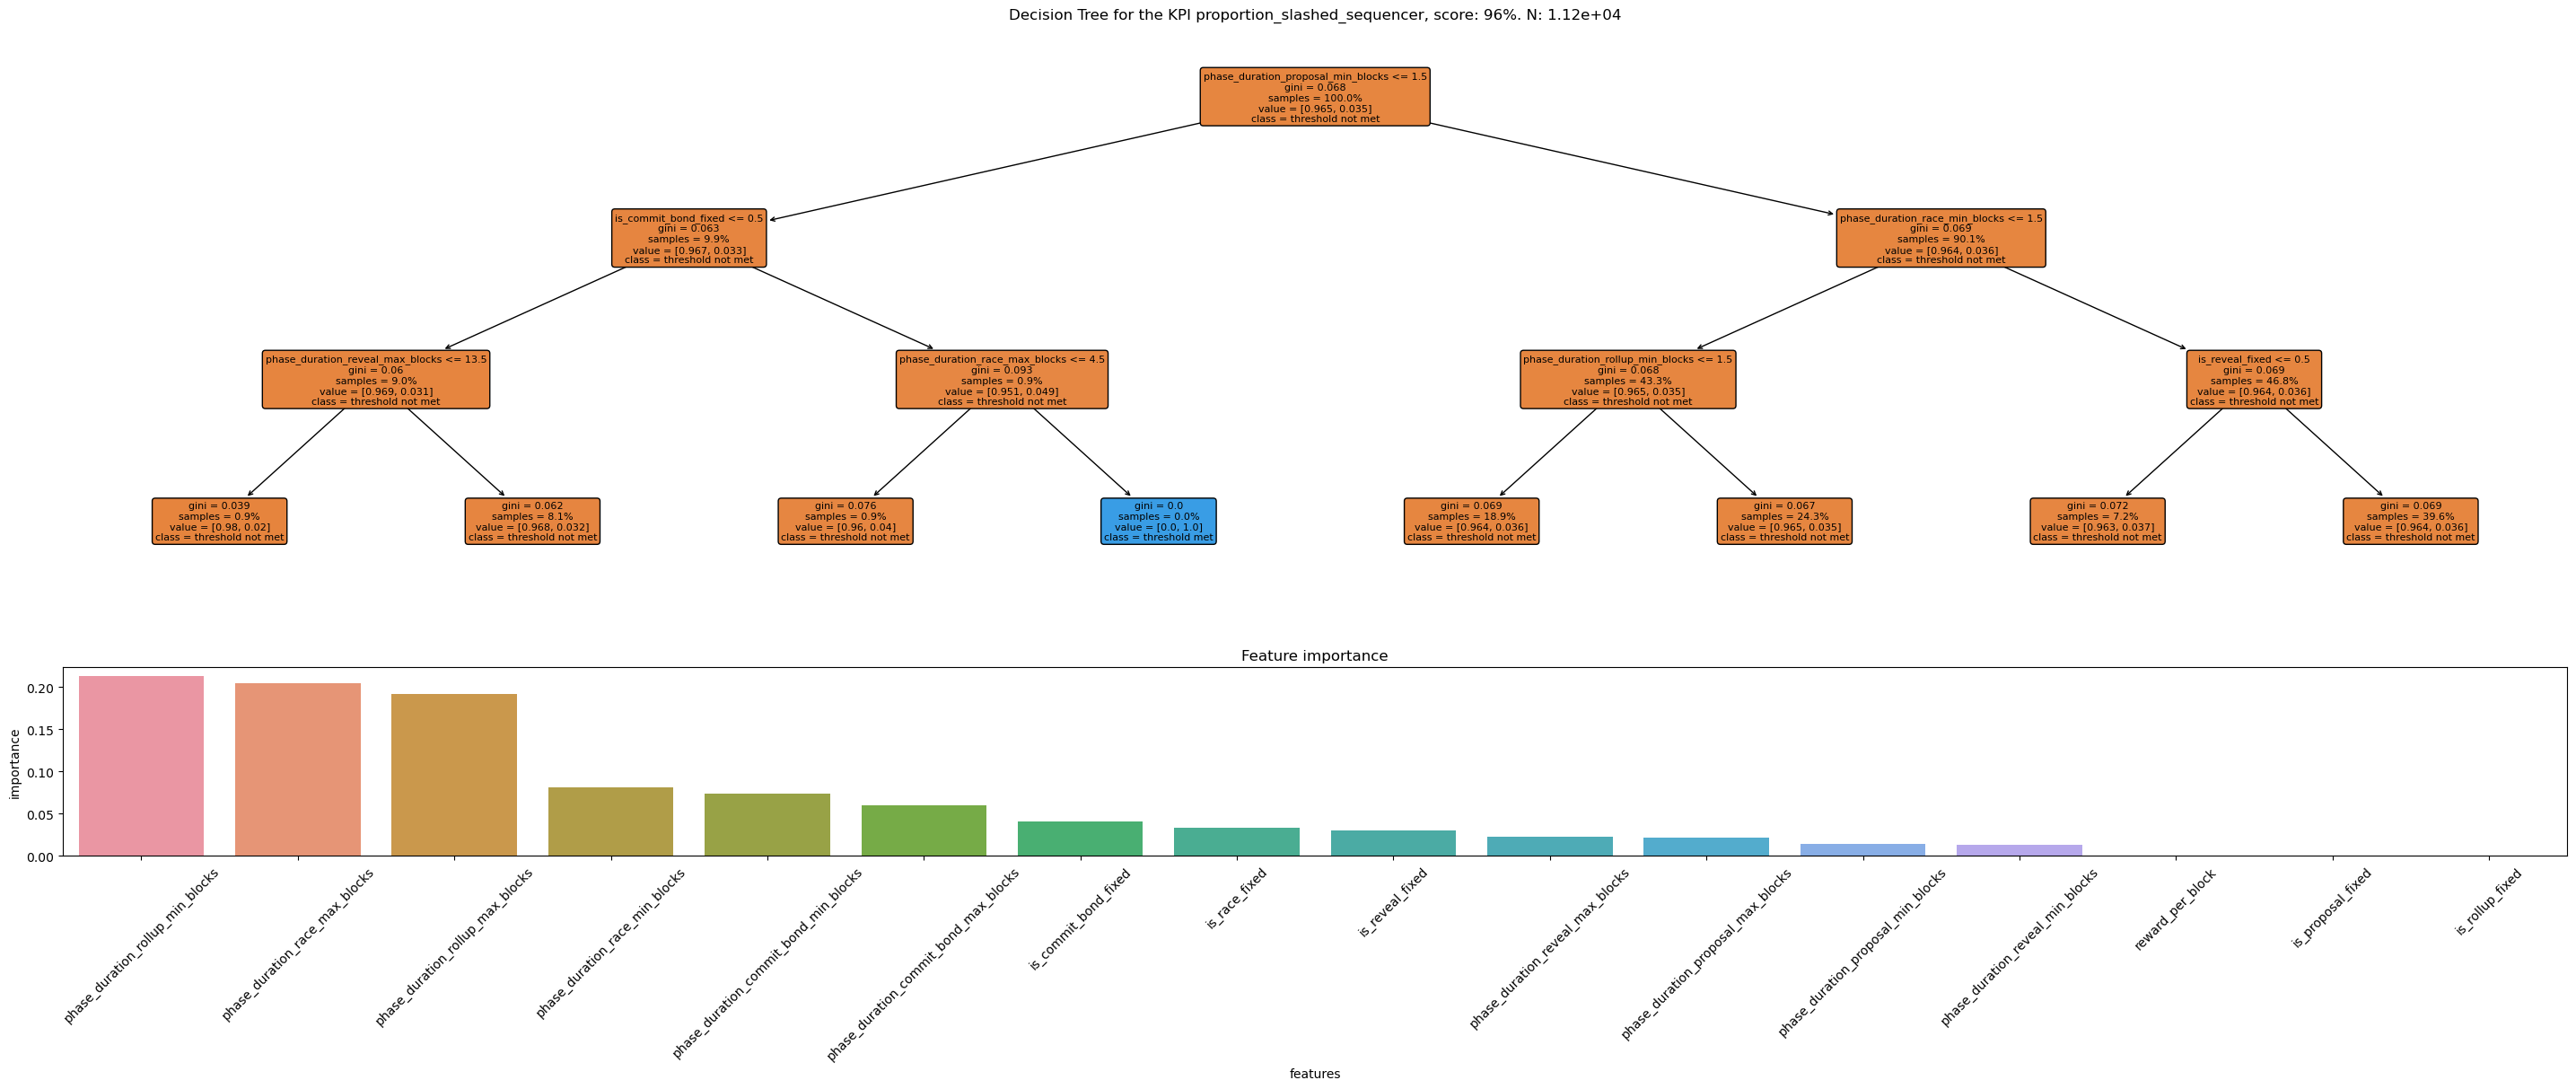

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI proportion_slashed_sequencer, score: 96%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [8]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "proportion_slashed_sequencer")

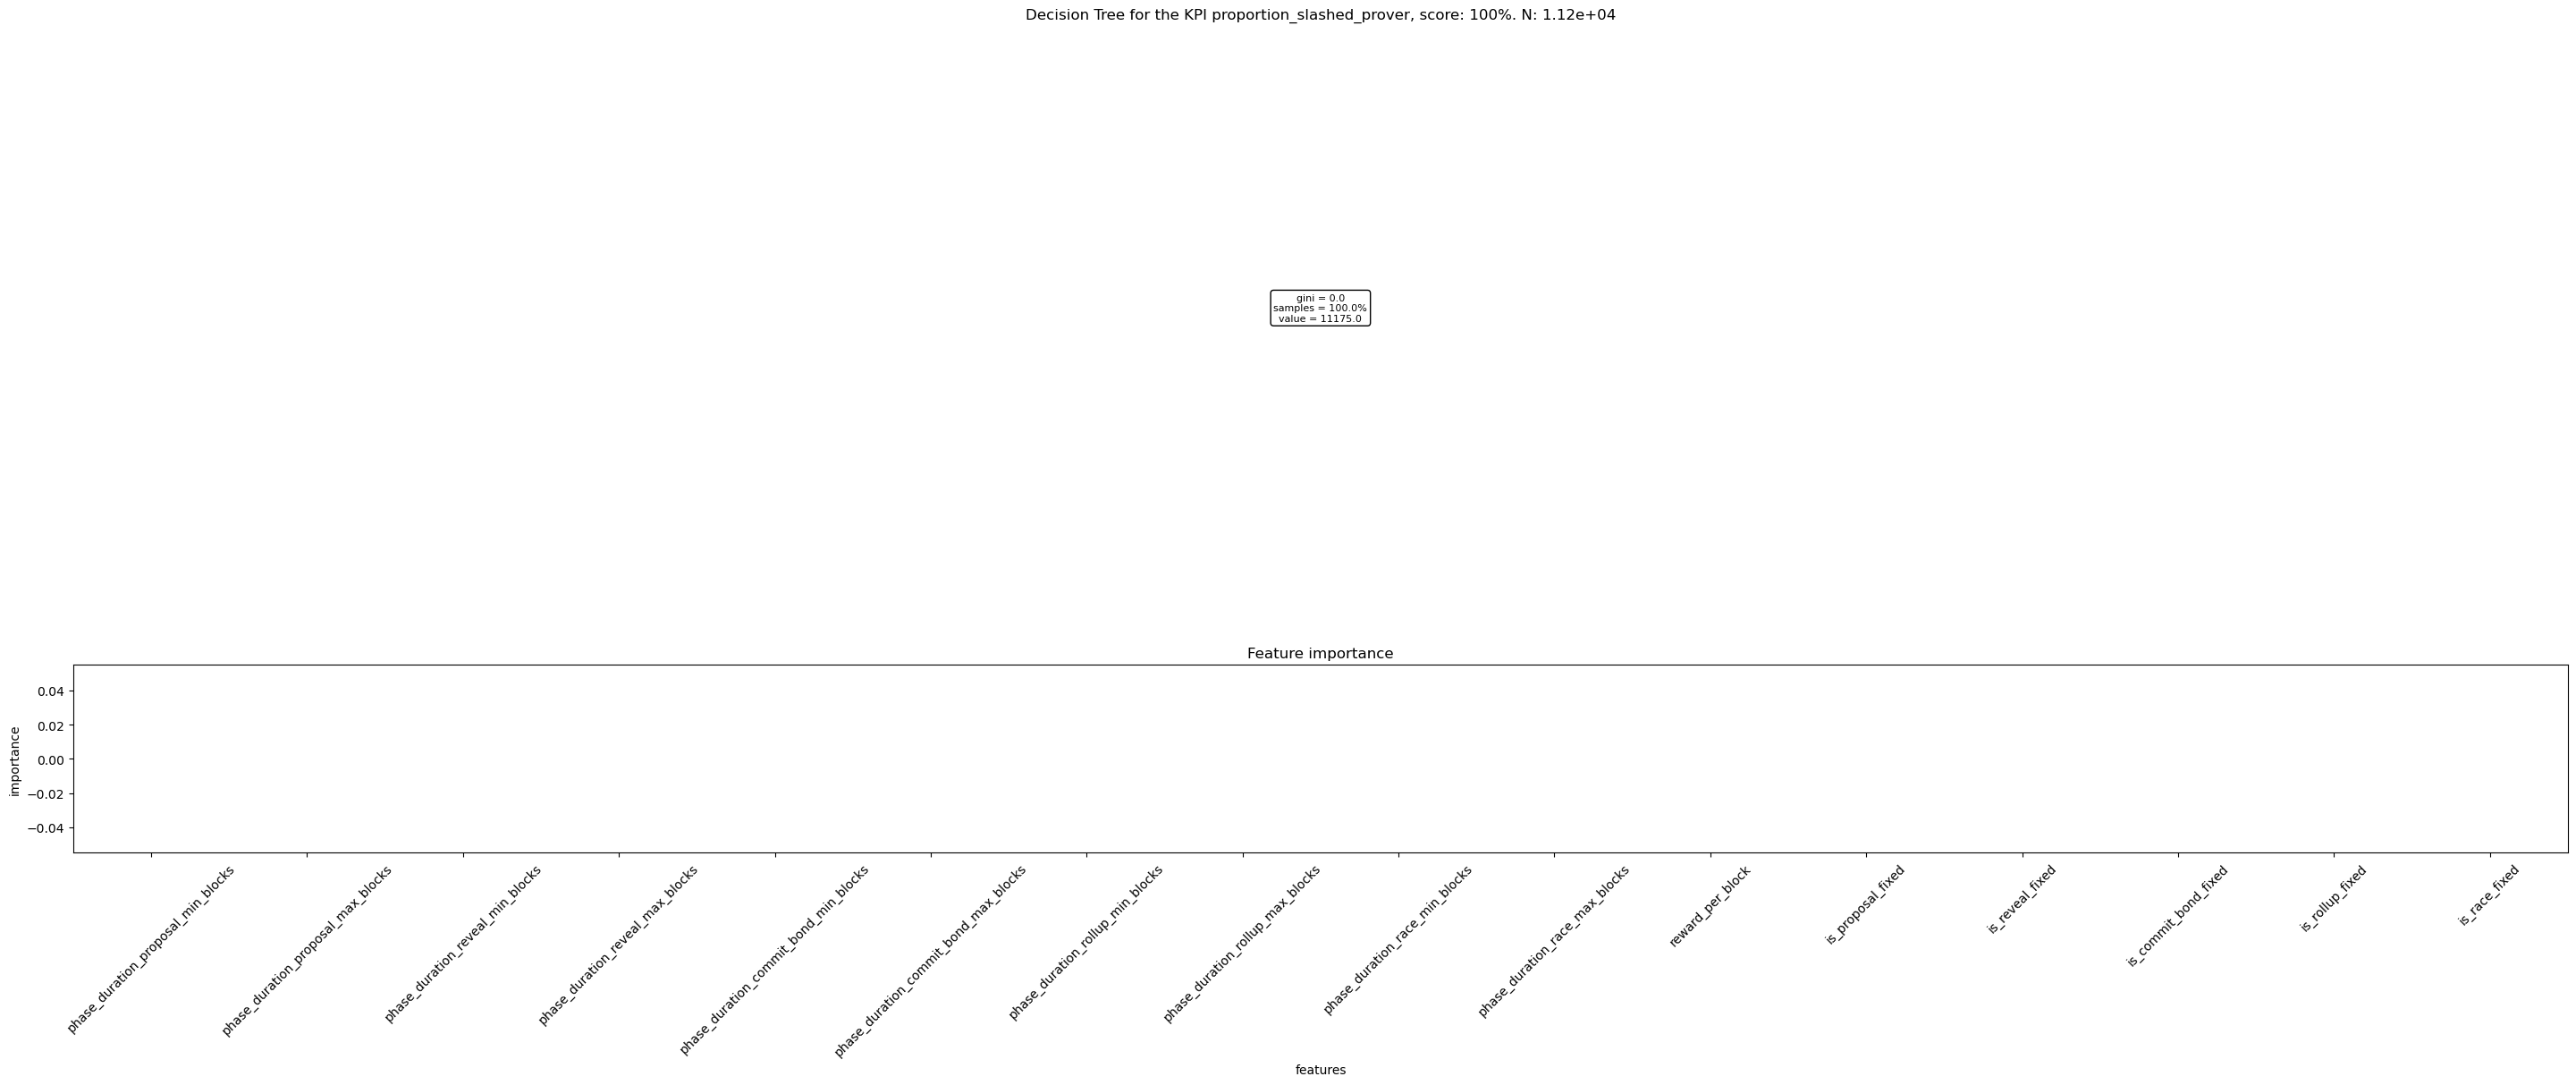

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI proportion_slashed_prover, score: 100%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [9]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "proportion_slashed_prover")

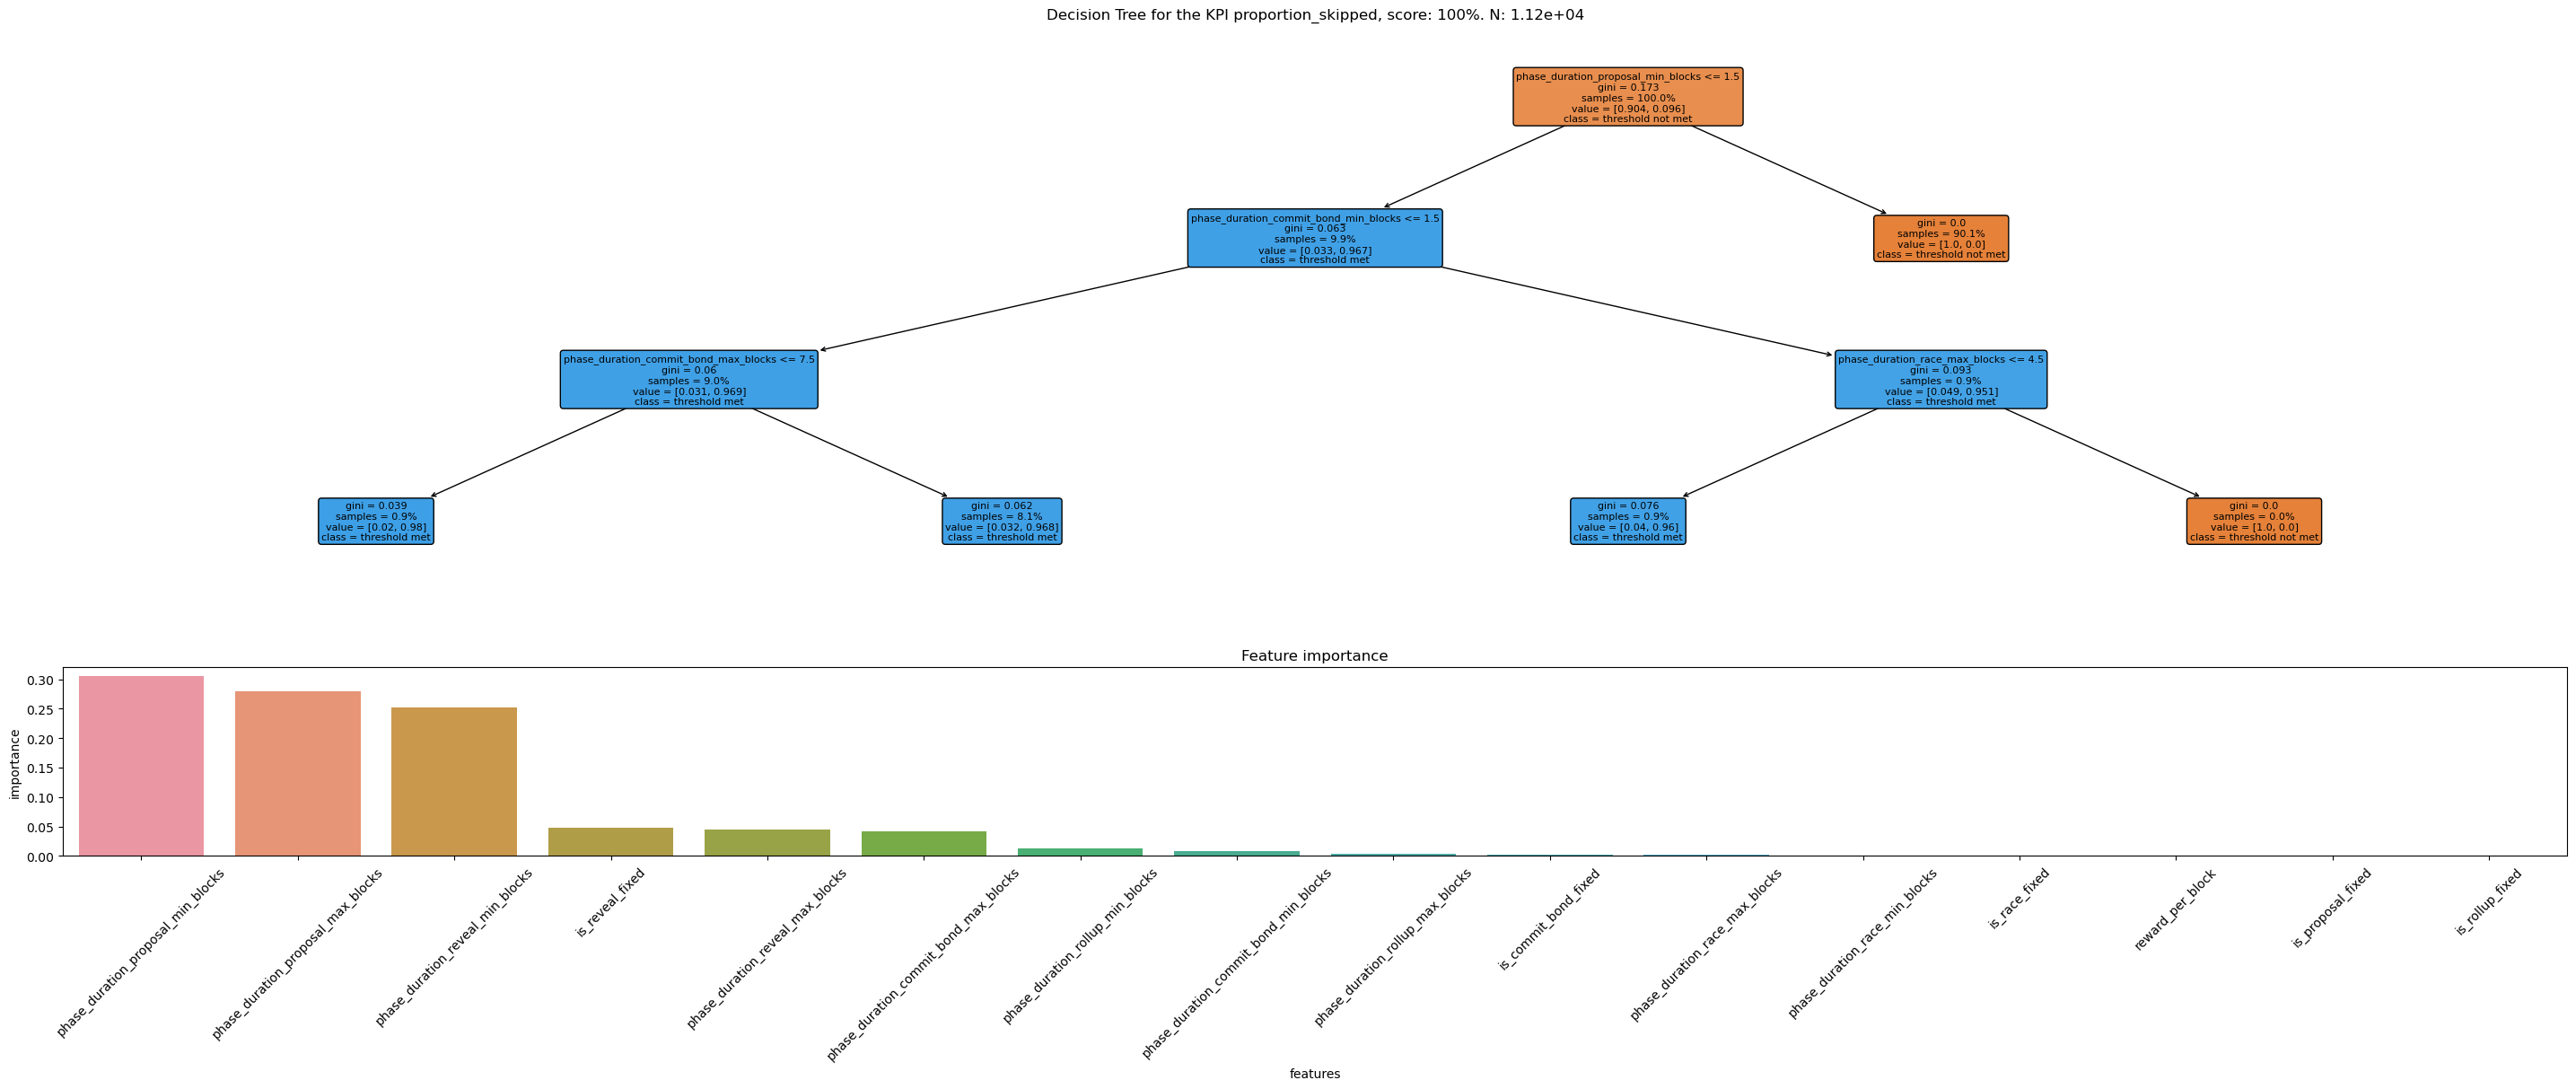

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI proportion_skipped, score: 100%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [10]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "proportion_skipped")

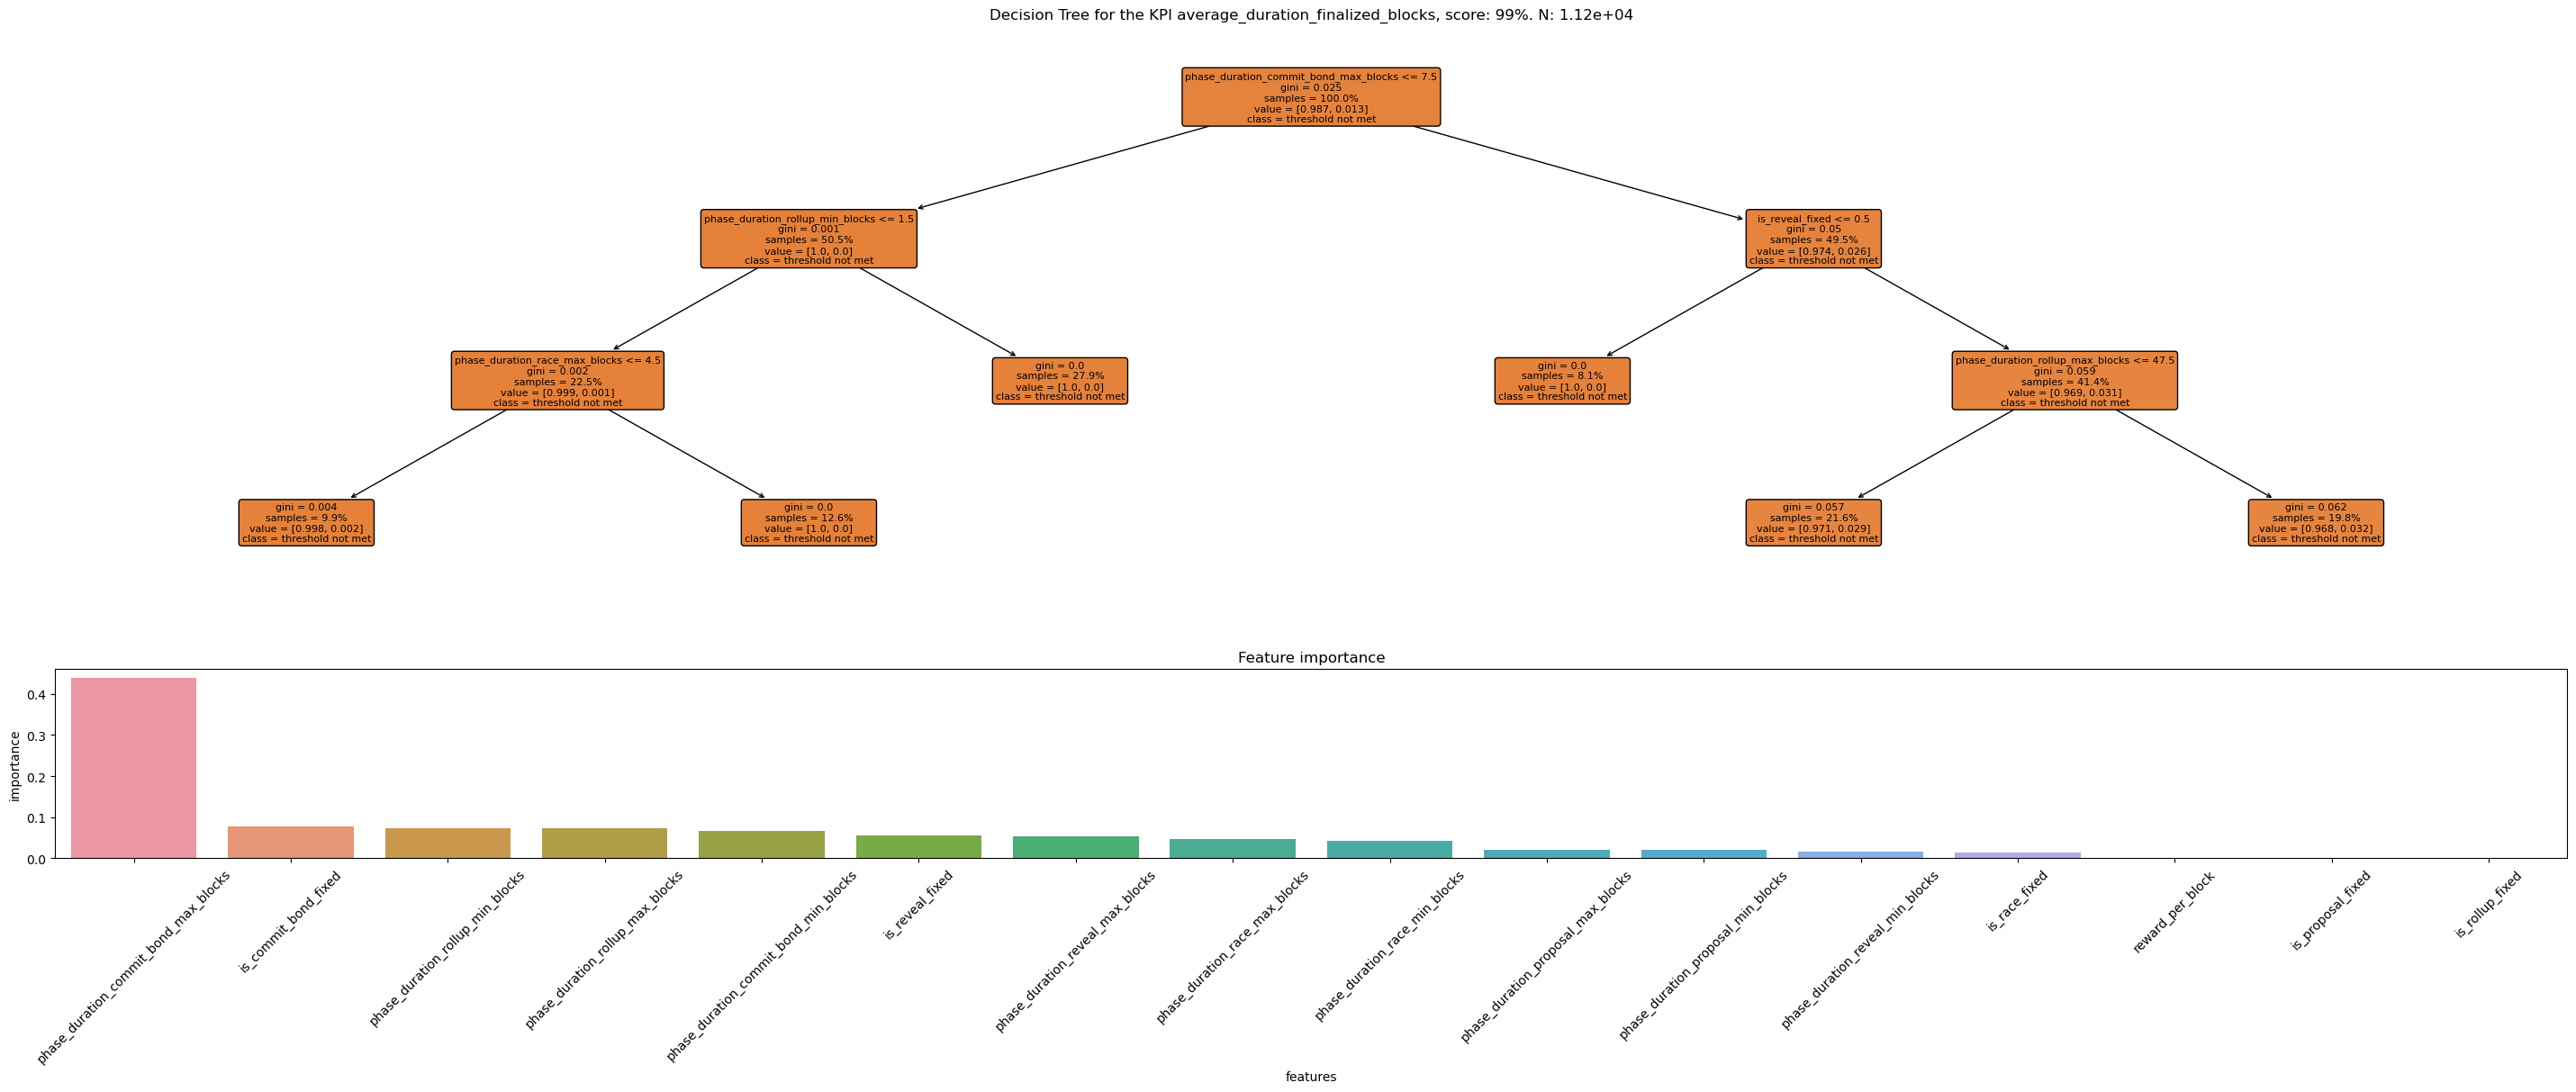

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI average_duration_finalized_blocks, score: 99%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [11]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "average_duration_finalized_blocks")

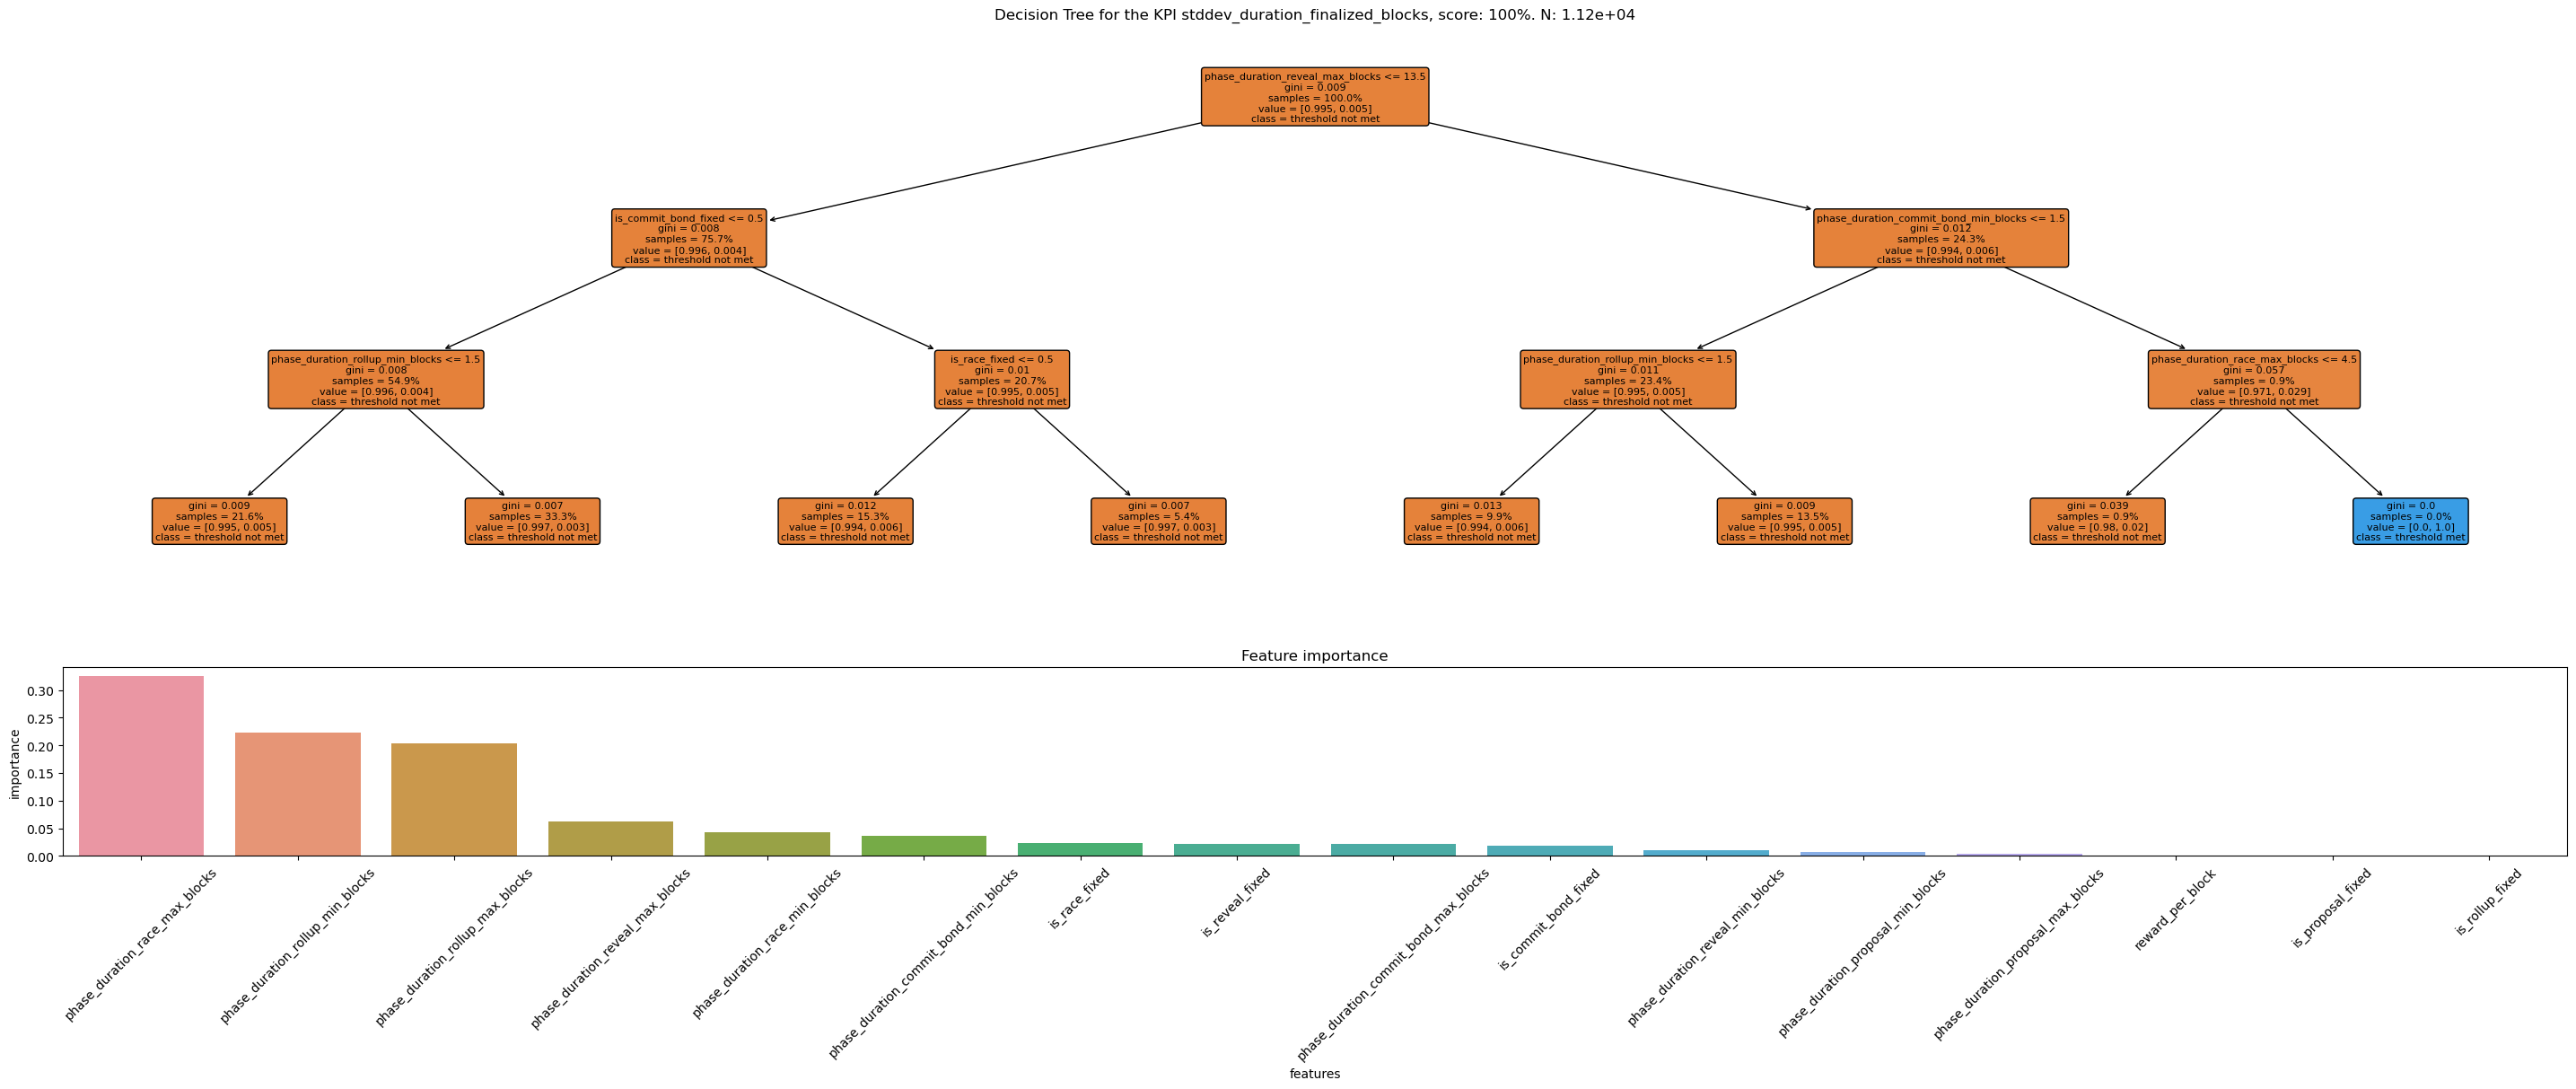

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI stddev_duration_finalized_blocks, score: 100%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [12]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "stddev_duration_finalized_blocks")

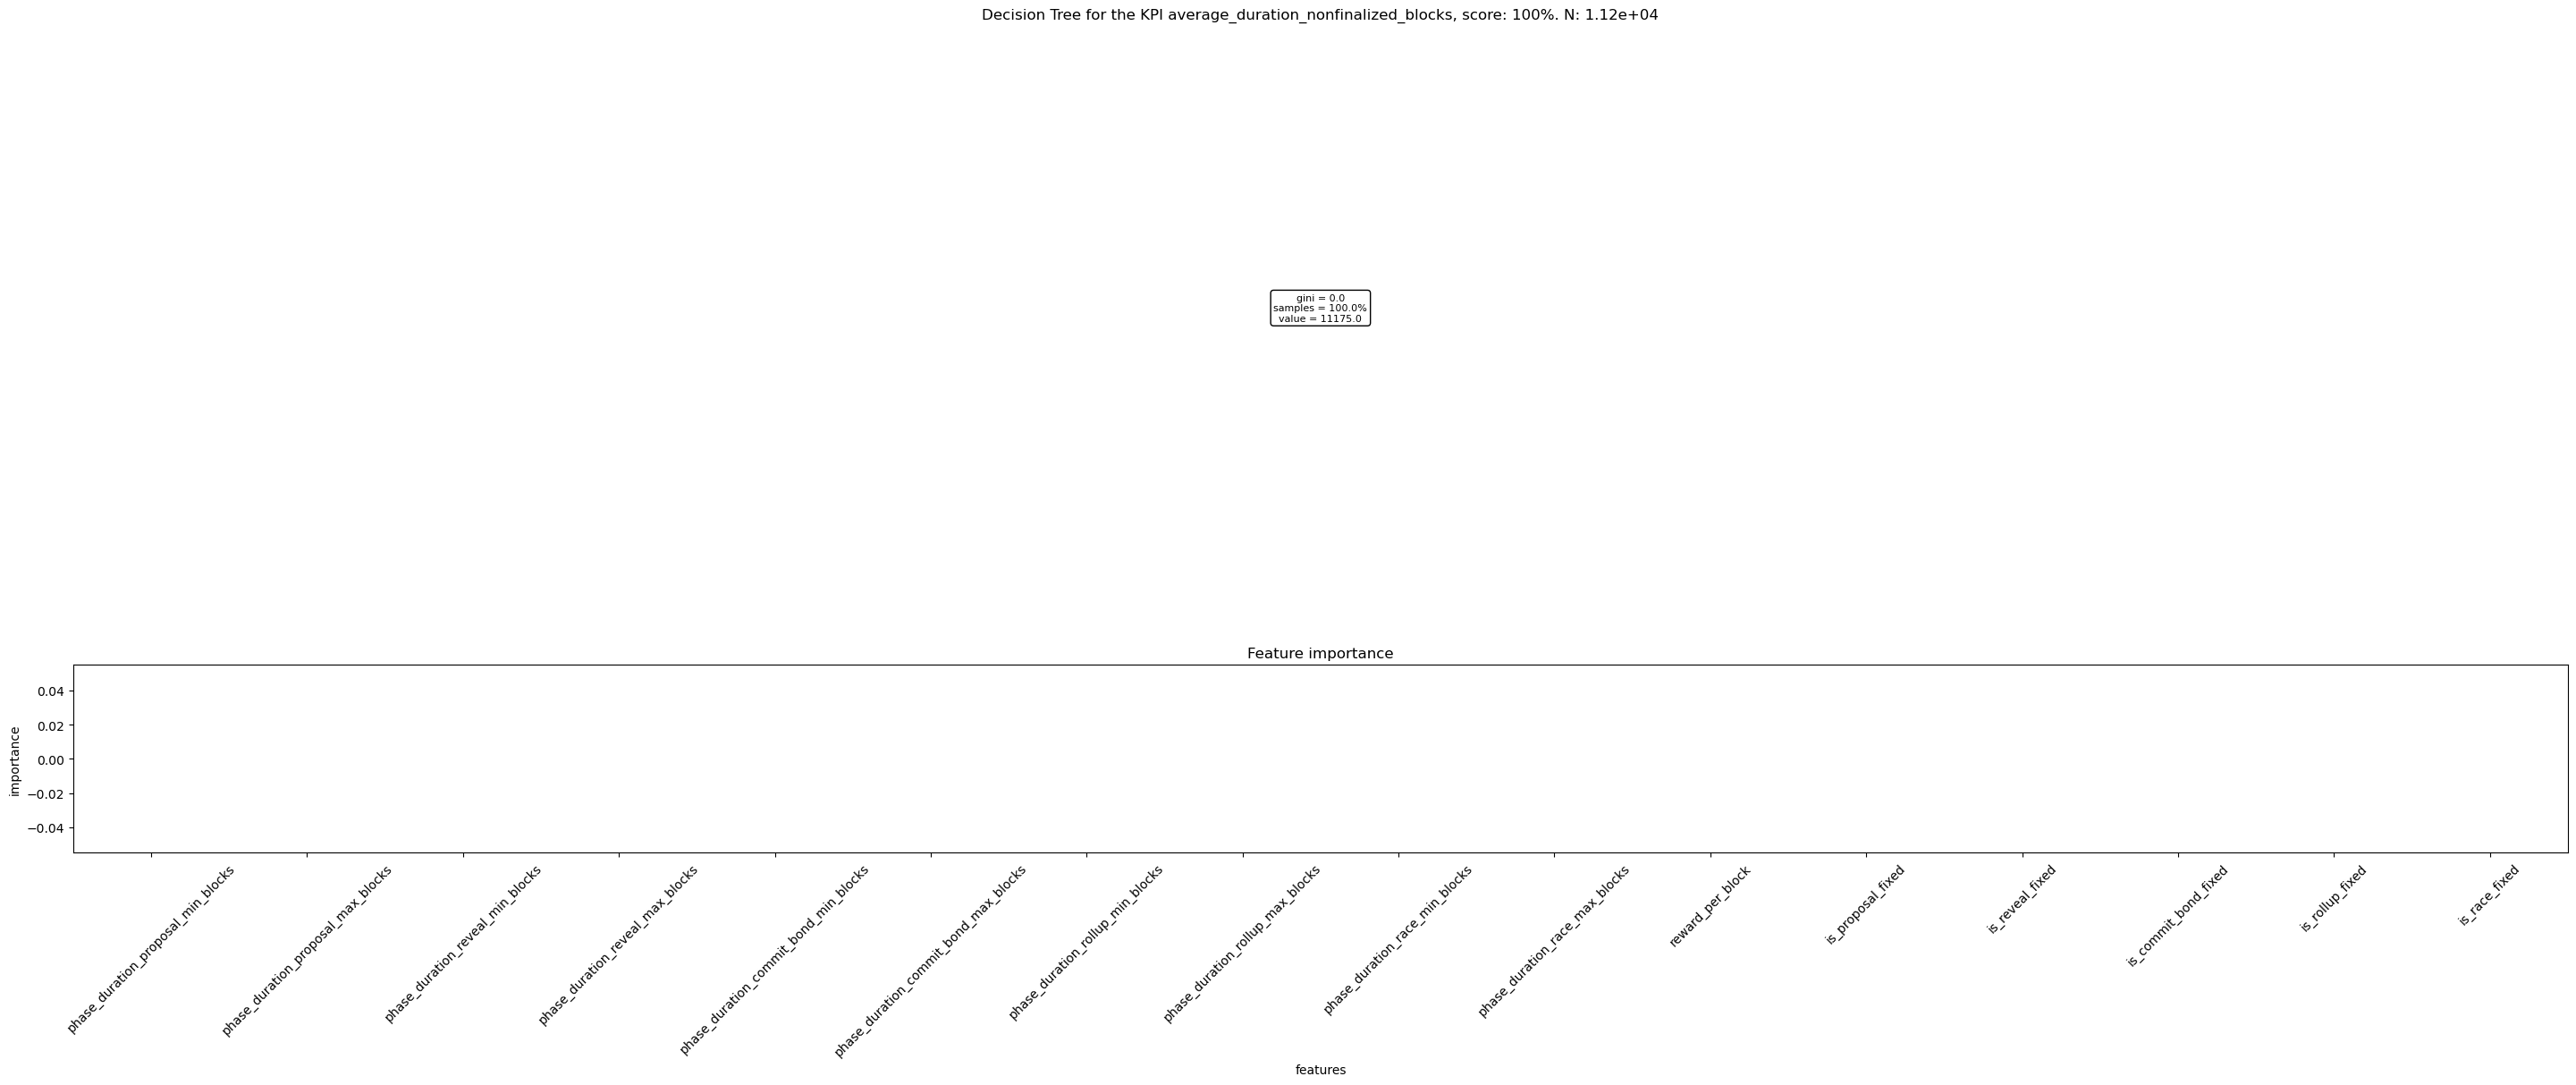

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI average_duration_nonfinalized_blocks, score: 100%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [13]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "average_duration_nonfinalized_blocks")

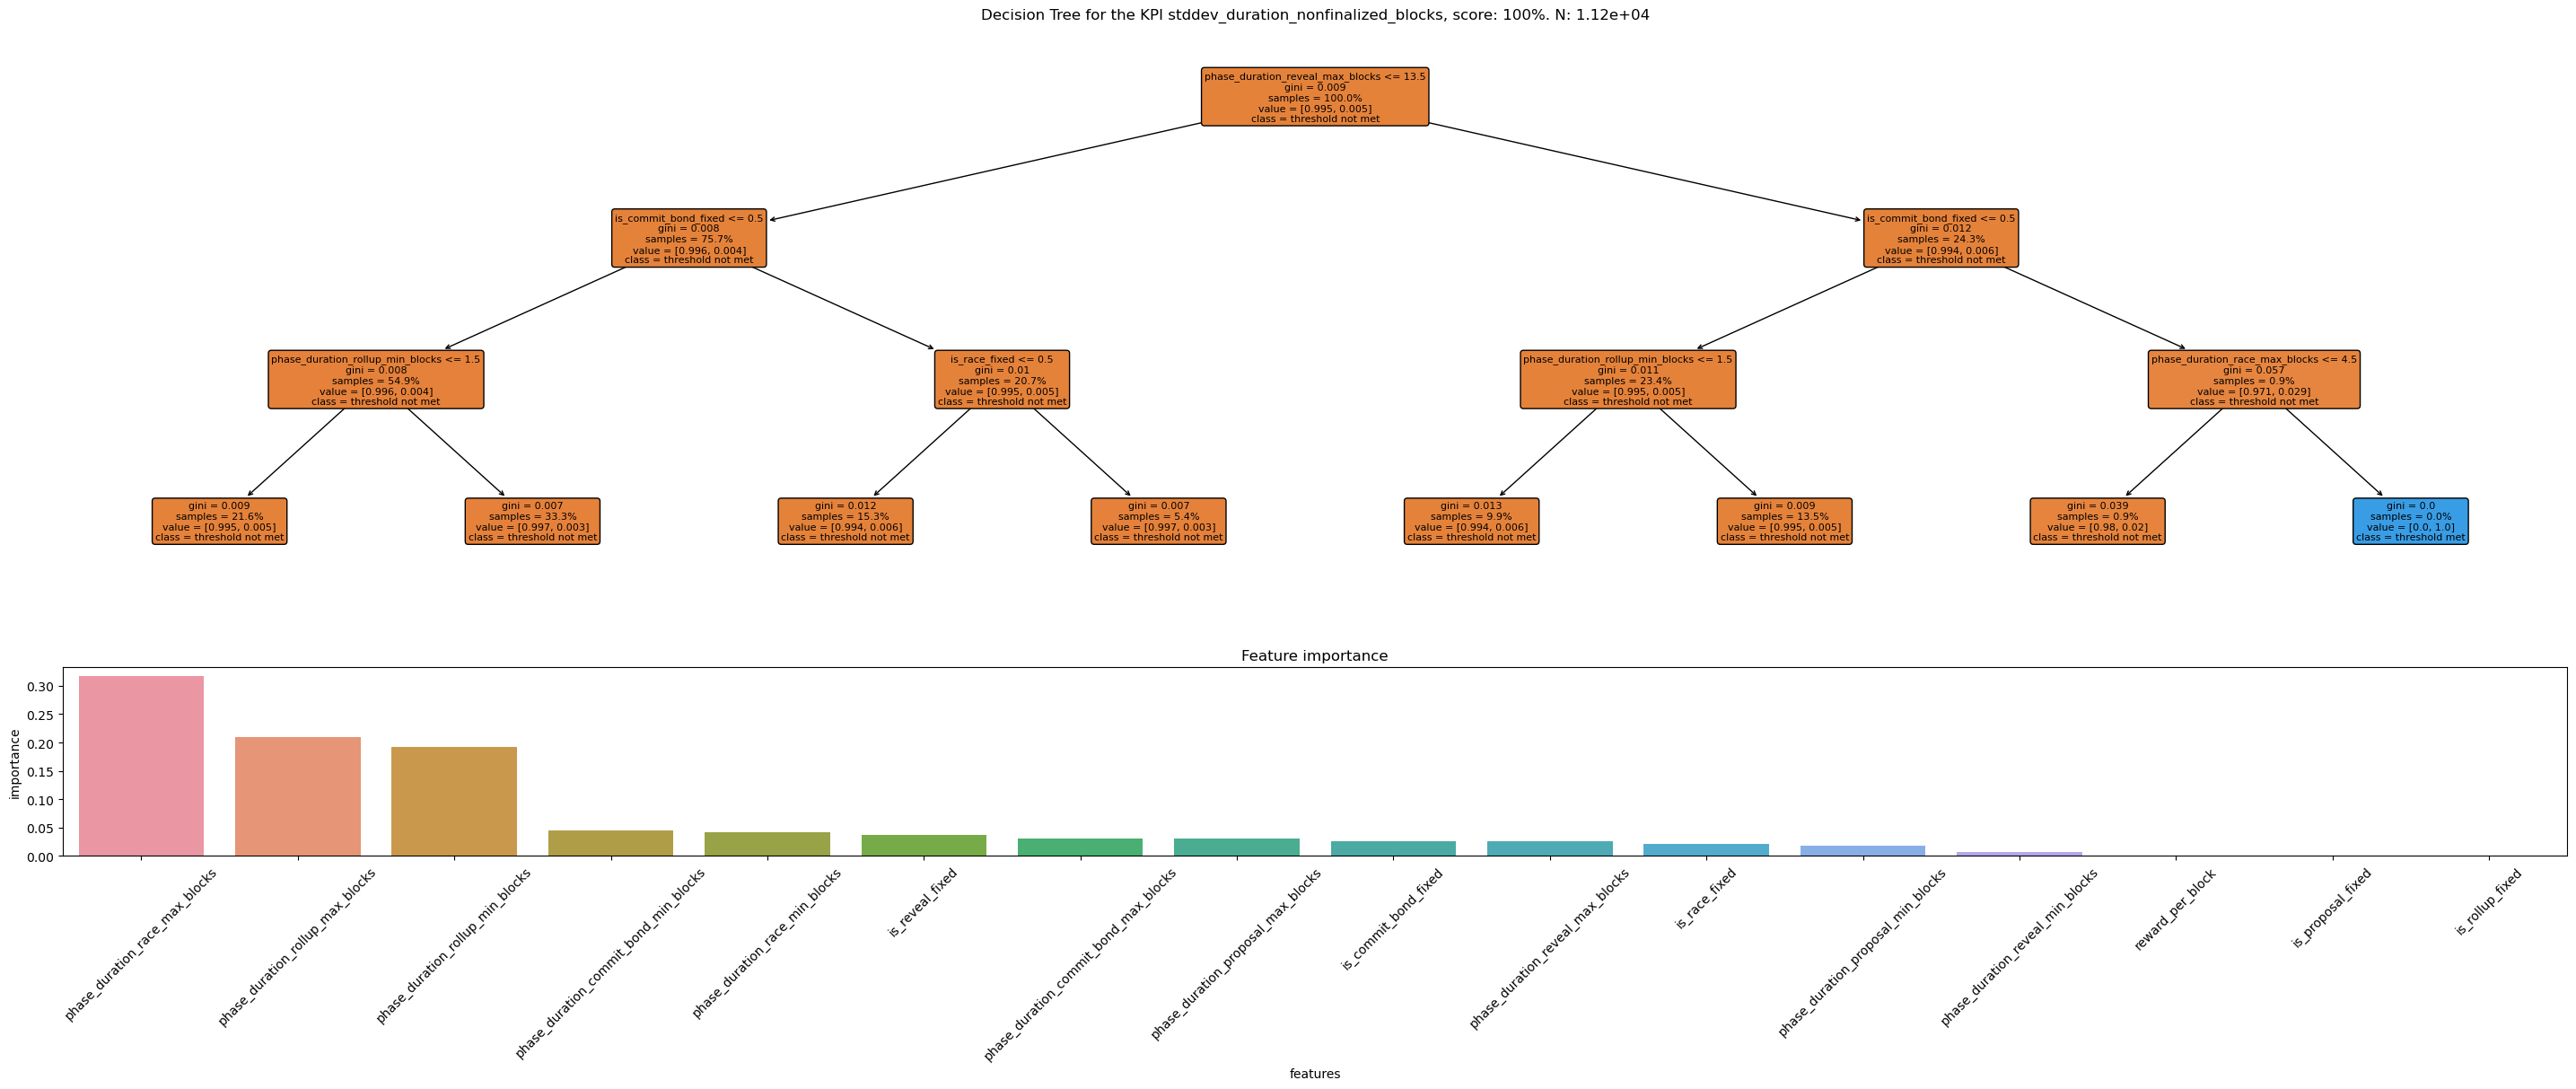

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI stddev_duration_nonfinalized_blocks, score: 100%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [14]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "stddev_duration_nonfinalized_blocks")

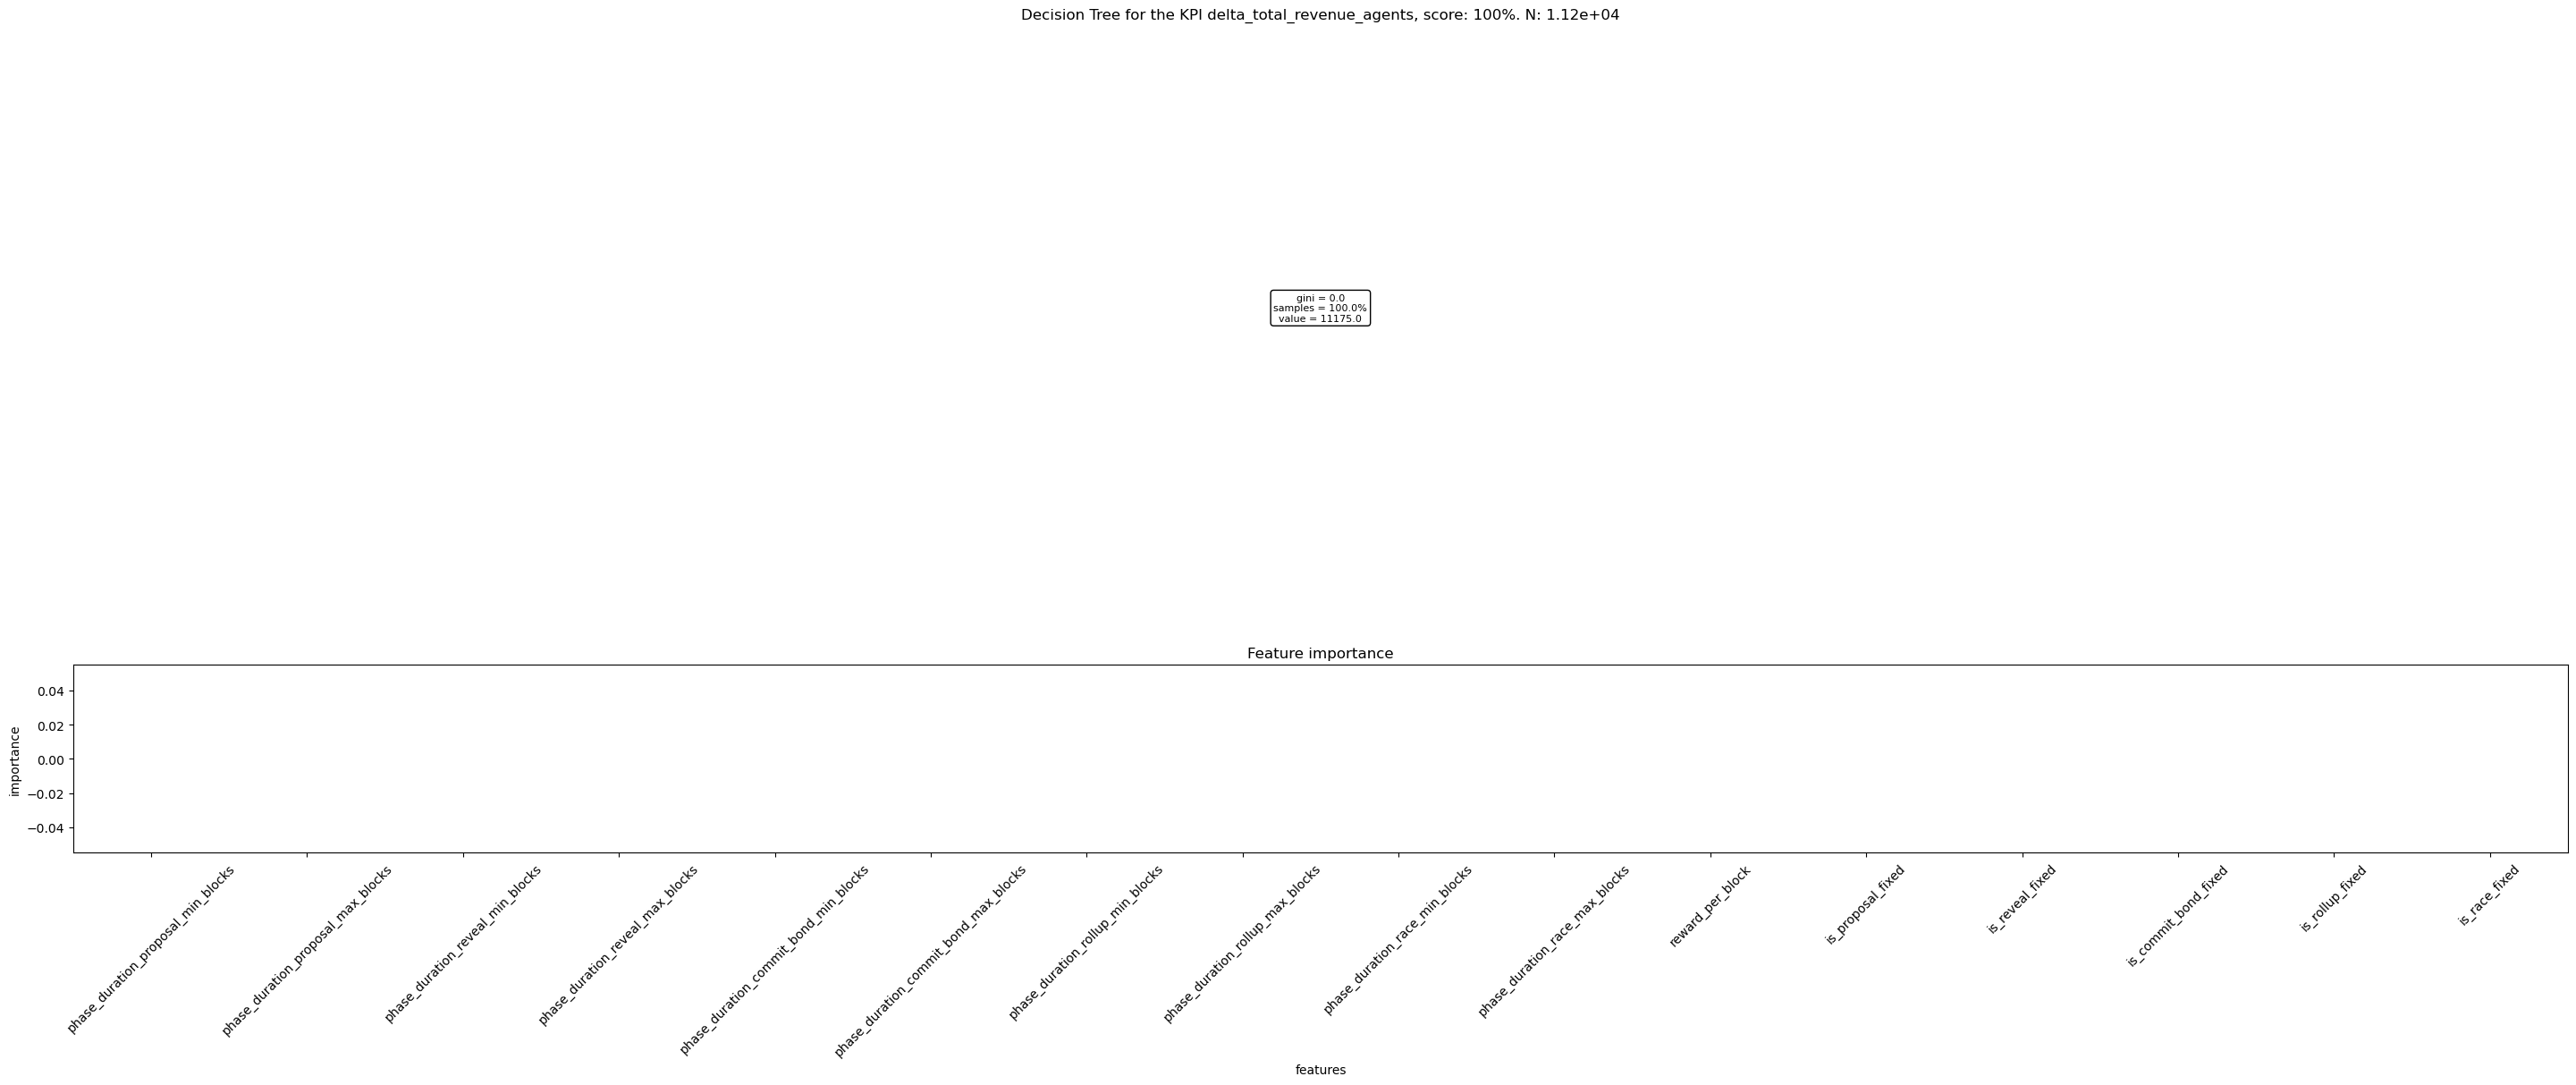

(<Figure size 3600x1200 with 2 Axes>,
 array([<Axes: title={'center': 'Decision Tree for the KPI delta_total_revenue_agents, score: 100%. N: 1.12e+04'}>,
        <Axes: title={'center': 'Feature importance'}, xlabel='features', ylabel='importance'>],
       dtype=object))

In [15]:
create_decision_tree_importances_plot(data = base_df,
                                      kpi = "delta_total_revenue_agents")    

# Parameter Impact on KPIs

The simulation results provide, for each combination of swept protocol parameter values ("parameter constellations"), a series of outcomes distinguished by different random realizations of stochastic ("Monte Carlo") distributions. Thus, each of the KPIs can be computed for each simulation result, and a _frequency distribution_ or _density_ of KPI values can be generated for each of the iterations of the adaptive grid approach. These densities can be further broken down by protocol parameter value, and the changes in the densities across different values can be visualized. This provides a method of assessing the sensitivity of the KPIs to the protocol parameters, both at the initial adaptive grid implementation, before optimization is performed, and at the end of the implementation, when the recommended parameter ranges have been achieved.

Each group of figures below corresponds to one of the protocol parameters. Each row in a figure group corresponds to a different KPI, and each column to the initial adaptive grid and final adaptive grid simulation results. Within a figure, the density corresponding to each swept value of the associated protocol parameter is presented (generally, the lower sweep value is displayed in black, while the upper sweep value is in red, although this may not always be the case). 

By examining the changes in the shape of the KPI densities across sweep values and across the adaptive grid results, a qualitative visual assessment of how sensitive the KPI under scrutiny is to the swept protocol parameter can be made.

/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

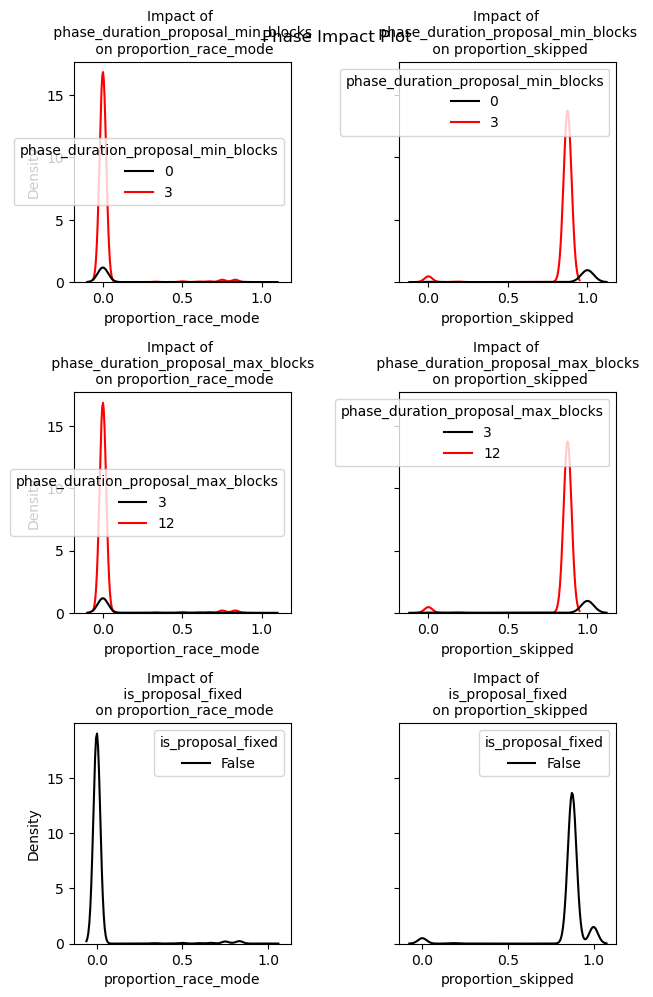

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_proposal_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_proposal_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_proposal_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [16]:
# TODO: Create parameter importances plot by column. 

create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "proposal",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])


/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

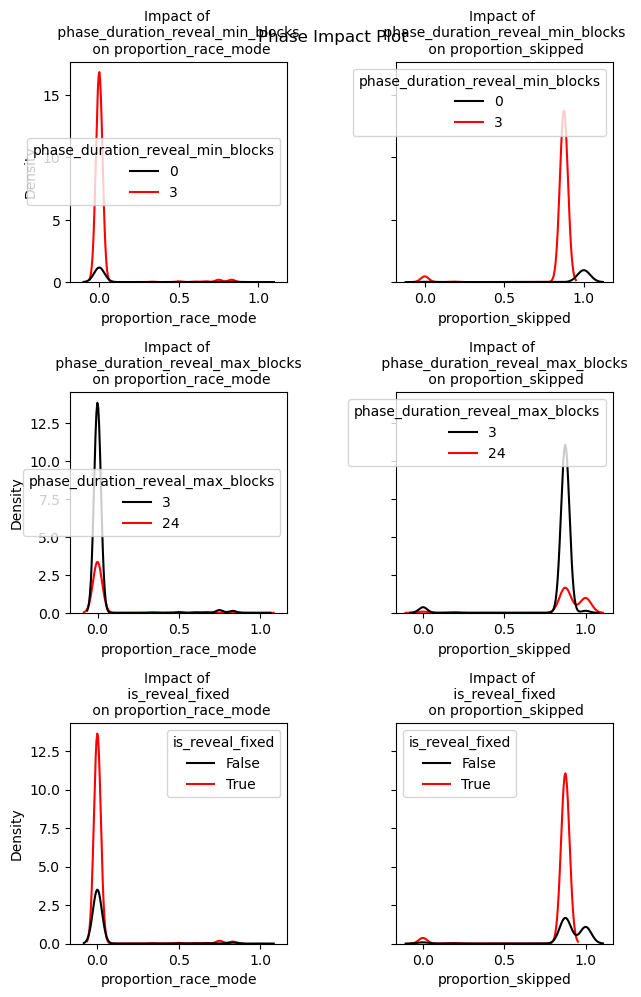

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_reveal_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_reveal_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_reveal_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [17]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "reveal",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

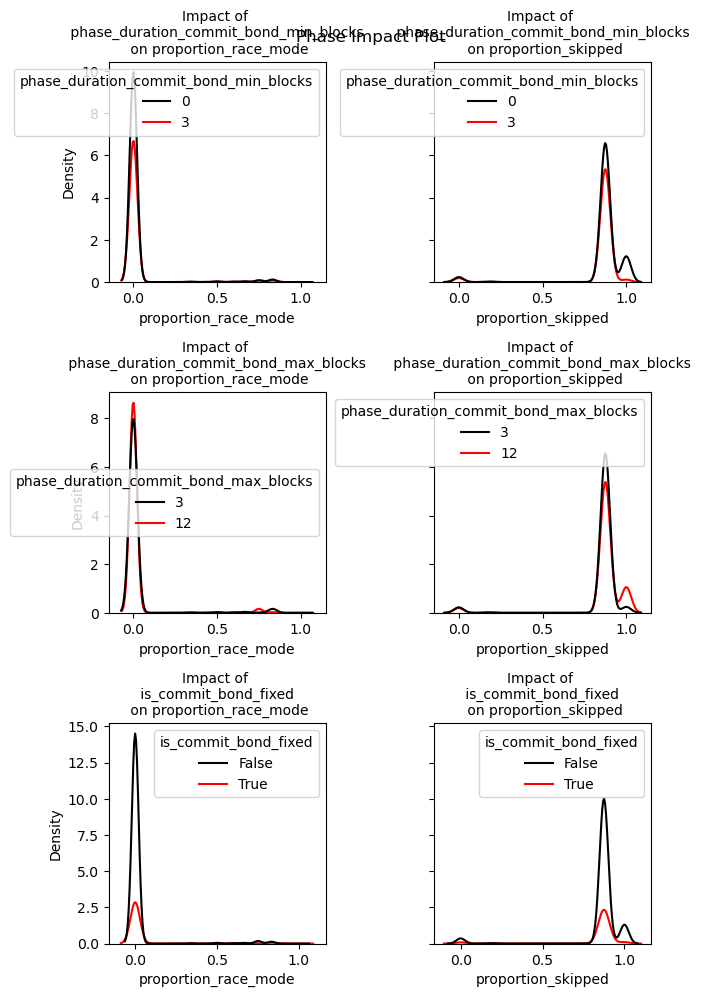

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_commit_bond_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_commit_bond_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=ob

In [18]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "commit_bond",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

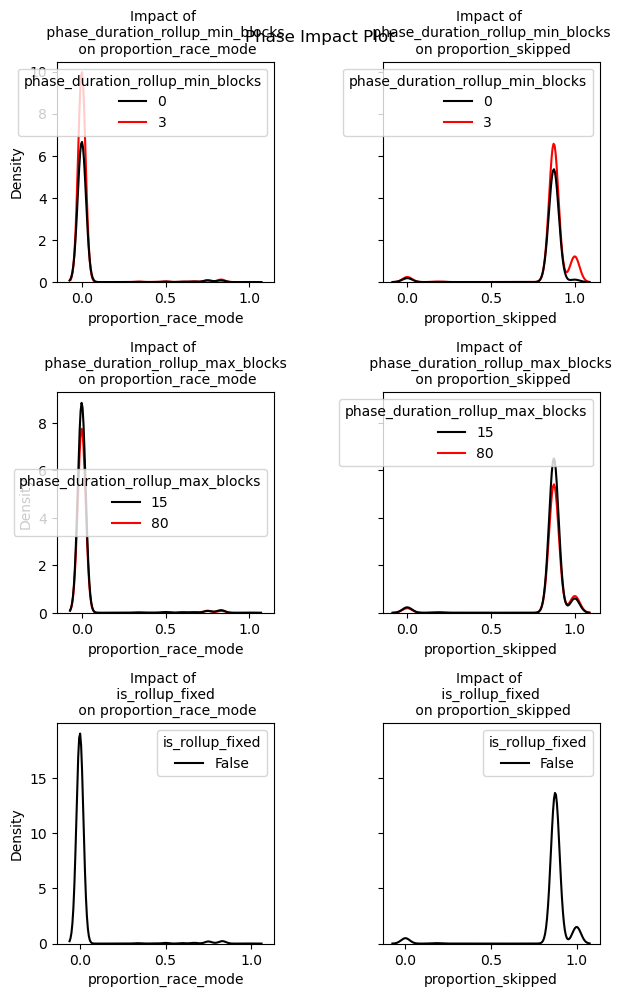

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_rollup_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_rollup_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_rollup_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [19]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "rollup",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/danlessa/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

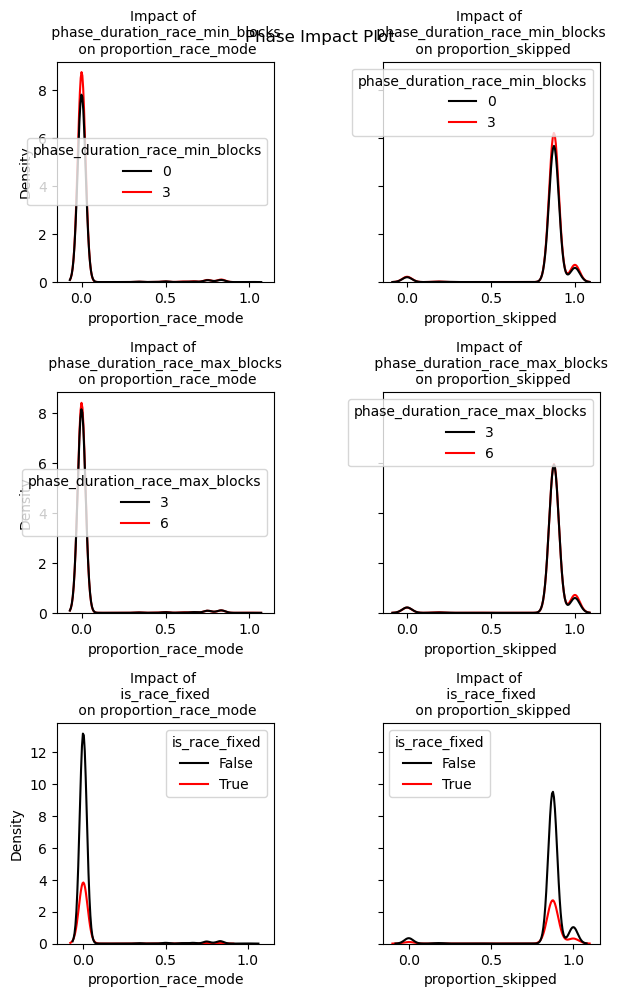

(<Figure size 700x1050 with 6 Axes>,
 array([[<Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_min_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n phase_duration_race_max_blocks \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>],
        [<Axes: title={'center': 'Impact of \n is_race_fixed \n on proportion_race_mode'}, xlabel='proportion_race_mode', ylabel='Density'>,
         <Axes: title={'center': 'Impact of \n is_race_fixed \n on proportion_skipped'}, xlabel='proportion_skipped', ylabel='Density'>]],
       dtype=object))

In [20]:
create_phase_impact_dist_plots_by_kpi(df_to_use = base_df,
                                      phase = "race",
                                      kpi_cols = ["proportion_race_mode","proportion_skipped"])

# Conclusion

As is evident from the adaptive grid search results and the decision tree analysis, the success criteria for the **servicer profitability** and **servicer capital costs** threshold inequalities were met for every parameter constellation tested. This implies that either 1) initial parameter ranges were fortuitously selected within the overall parameter space for these criteria, or 2) the success criteria for the servicer are loose and can be tightened--note in particular that servicer NPV is _lifetime_ discounted profitability, and so perhaps 750 POKT as a threshold value is too low.

The success criteria for the **gateway NPV** was the main delineator for parameter values, as desired for this scenario group. The decision tree analysis indicates that the `GFPR` range of $(10, 12.8125)$ uPOKT and `GMS` range of $(1.22e5, 1.25e5)$ are both consistent with threshold satisfaction, and that the `GFPR` contains the 'lion's share' of importance. This is in line with expectations. Furthermore, the density impact results clearly show that the gateway NPV KPI was most sensitive to changes in all swept protocol parameters, with `GFPR` and `GMS` providing the most impact--generally speaking, the higher were these two parameters, the less variability was observed in the gateway NPV (this is more marked in the changes over `GFPR` in the final adaptive grid results). `GMS` also had an impact on the servicer capital costs KPI, again reducing the variability of its density in the final adaptive grid results. 

A striking result is the higher recommended value of `AFPR` (range $(26.875, 29.6875)$ uPOKT) when compared with `GFPR`. On its own this may provide an incentive for applications to 'masquerade' as gateways, serving their own relay requests and incurring the lower `GFPR`. However, the significantly higher staking requirements [`GMS` $(1.22e5, 1.25e5)$ POKT vs. `AMS` $(1.35e4, 1.38e4)$ POKT] indicate that for this 'masquerade' to be profitable, a single application's relay traffic volume must be high. Understanding the degree to which 'high' is 'high enough' is a promising avenue for future simulation work.

Finally, the range for the `TTRM` $(71.875, 83.59735)$ indicates that a slight restriction of bandwidth below the initial estimate of $100$ does not appear to materially affect the profitability of servicers or gateways. This may be useful to assess expected network load or capacity constraints for expected relay traffic.